In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# Defining a Class
class GraphVisualization:

    def __init__(self):

        # visual is a list which stores all
        # the set of edges that constitutes a
        # graph
        self.visual = []

    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
def showModel(model):
    G = GraphVisualization()
    for i in range(len(model)):
        for j in range(i):
            if(model[i][j]!=0):
                G.addEdge(i,j);
    G.visualize()

In [ ]:
import numpy as np
from scipy.special import expit as logsig
from scipy.stats import binom
import random
import matplotlib.pyplot as plt

def sampling_ising(A, N):
    """
    Sample from an Ising model with weight matrix A
    A is the weight matrix, A_ij = A_ji, assuming the mean-field = 0
    """
    s = A.shape[0]
    all_states = np.array([(np.array(list(bin(i)[2:].zfill(s)), dtype=int)*2-1) for i in range(2**s)])  #generates all states
    probs = np.array([np.exp(x @ A @ x.T / 2) for x in all_states])
    probs = probs / probs.sum()
    samples_idx = np.random.choice(2**s, size=N, p=probs)
    samples = all_states[samples_idx]           #maps index of chosen state to actual state
    return samples

def sampling_diamond(s, theta, rand_sign, num_sample):
    """
    Sampling from an Ising model with diamond graph structure
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    """
    A = np.zeros((s, s))
    A[0, 1:s-1] = theta
    A[s-1, 1:s-1] = theta
    A[1:s-1, 0] = theta
    A[1:s-1, s-1] = theta
    if rand_sign:
        sign_mat = np.triu((binom.rvs(1, 0.5, size=(s, s))*2-1), 1)
        A = A * (sign_mat + sign_mat.T)  # make it symmetric

    samples = sampling_ising(A, num_sample)
    showModel(A)
    return A, samples
def genDDegreeGraph(s, theta, rand_sign,d):
    G = nx.random_regular_graph(d=d,n=s);
    A = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            if i!=j and G.has_edge(i,j):
                A[i][j] = theta*(-1 if rand_sign and random.random()<.5 else 1)
    return A
def showMat(model):
    for i in range(len(model)):
        for j in range(len(model)):
            try:
                print("{0:.4f}".format(model[i][j]),end = " ")
            except:
                print(model[i][j],end=" ")
        print()

def mirror_descent(X, y, T, W1):
    """
    Use mirror descent to solve a logistic regression problem
    with simplex constraint:
    x_{t+1} = x_t exp(-eta*grad), x_{t+1} = x_{t+1} / ||x_{t+1}||_1
    """
    d = X.shape[1]
    N = X.shape[0]
    eta = np.sqrt(2 * np.log(d) / T) / (2 * W1)
    w = np.ones(d) / d
    w_sum = w.copy()

    for t in range(T):
        preds = logsig(X @ w) - y
        grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)  # could use stochastic gradient
        w = w * np.exp(-eta * grad)
        w = w / w.sum()
        w_sum = w_sum + w

    w_avg = w_sum / T
    # compute the gradient norm at w_avg
    preds = logsig(X @ w_avg) - y
    grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)
    g_norm = np.linalg.norm(grad)

    return w_avg, g_norm

def ising_learn(graph_size, num_sample, theta, rand_sign, num_iter):
    """
    graph_size: indicates the size of the graph; theta: weight of each edge
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    num_samples: number of samples; num_iter: number of mirror descent iterations
    """
    s = graph_size
    A, Xs = sampling_diamond(s, theta, rand_sign, num_sample)
    W1 = 2 * (s - 2) * theta
    A_hat = np.zeros((s, s))
    for i in range(s):
        y = (Xs[:, i] + 1) / 2
        X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        print(X)
        w, _ = mirror_descent(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2
    showModel(A)
    showMat(A_hat)
    showModel([[abs(A_hat[i][j])>.004 for j in range(s)]for i in range(s)])
    error = np.max(np.abs(A - A_hat))
    return error

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def makeDDegree(s,A_hat):
    topEdges = sorted([(abs(A_hat[i,j]),i,j) for j in range(s) for i in range(s)],reverse=True)
    out = np.zeros((s, s))
    degree = [0]*s;
    for weight,i,j in topEdges:
        if out[i][j]==0 and degree[i]<d and degree[j]<d:
            degree[i]+=1
            degree[j]+=1
            out[i][j] = A_hat[i,j]
            out[j][i] = out[i][j]
    return out
def learn(samples,num_iter,W1):
    s = len(samples[0])
    num_sample=len(samples)
    gamma = np.sqrt(2*np.log(2*s+1)/num_iter)/2/W1
    A = np.zeros((s,s));
    for i in range(s):
        # w = np.ones(2*s-1)/(2*s-1)
        w=np.random.rand(2*s-1)
        w/=sum(abs(w))
        iter=0;
        for t in range(num_iter):
            prev= w.copy()
            grad = np.zeros(2*s-1);
            for sample_ind in range(num_sample):
                x = np.hstack([samples[sample_ind][:i],samples[sample_ind][i+1:]])
                x = np.hstack([x,-x,np.zeros(1)])*W1
                y = samples[sample_ind][i]
                grad+=(sigmoid(w @ x.T)-y)*x/num_sample
                # print(w,x,w @ x)
            w*=np.exp(-gamma*grad)
            w/=sum(abs(w))
            iter+=1
            if max(abs(w-prev))<.001:
                break
        w/=iter
        for p in range(s):
            if p==i:
                continue
            A[i,p] = (w[p-(p>i)]-w[p-(p>i)+s-1])*W1/2
    return A
def mirrorDescentSelfStopping(X, y, T, W1):
    """
    Use mirror descent to solve a logistic regression problem
    with simplex constraint:
    x_{t+1} = x_t exp(-eta*grad), x_{t+1} = x_{t+1} / ||x_{t+1}||_1
    """
    d = X.shape[1]
    N = X.shape[0]
    eta = np.sqrt(2 * np.log(d) / T) / (2 * W1)
    w = np.ones(d) / d
    w_sum = w.copy()
    tot = T;
    for t in range(T):
        w_prev = w.copy()
        preds = logsig(X @ w) - y
        grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)  # could use stochastic gradient
        w = w * np.exp(-eta * grad)
        w = w / w.sum()
        w_sum = w_sum + w
        if max(abs(w-w_prev))<.001:
            tot = t+1;
            break

    w_avg = w_sum / tot
    # compute the gradient norm at w_avg
    preds = logsig(X @ w_avg) - y
    grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)
    g_norm = np.linalg.norm(grad)

    return w_avg, g_norm

In [ ]:
def ising_learn_d_degree_graph_success(graph_size, samples, theta, num_iter,d,show = False):
    s = graph_size
    W1 = 2*d*theta
    # A_hat = learn(samples,num_iter,W1)
    # x = A_hat.copy()
    A_hat = np.zeros((s, s))
    num_sample = len(samples)
    for i in range(s):
        y = (samples[:, i] + 1) / 2
        X = np.hstack([samples[:, :i], samples[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        w, _ = mirrorDescentSelfStopping(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2
    out = makeDDegree(s,A_hat)
    return out
def ising_learn_graph(graph_size, samples, theta, num_iter,W1,show = False):
    s = graph_size
    # A_hat = learn(samples,num_iter,W1)
    # x = A_hat.copy()
    A_hat = np.zeros((s, s))
    print(s);
    num_sample = len(samples)
    for i in range(s):
        y = (samples[:, i] + 1) / 2
        X = np.hstack([samples[:, :i], samples[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        w, _ = mirrorDescentSelfStopping(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2
    return A_hat

In [ ]:
# def ising_learn_d_degree_graph(graph_size, num_sample, theta, rand_sign, num_iter,d,show = False):
#     """
#     graph_size: indicates the size of the graph; theta: weight of each edge
#     if rand_sign = True, then the sign of each edge weight is random
#     if rand_sign = False, then all edge weights = theta
#     num_samples: number of samples; num_iter: number of mirror descent iterations
#     """
#     s = graph_size
#     A, Xs = dDegreeGraphSampling(s, theta, rand_sign, num_sample,d)
#     W1 = 2 * (s - 2) * theta
#     A_hat = np.zeros((s, s))

#     for i in range(s):
#         y = (Xs[:, i] + 1) / 2
#         X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
#         X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
#         w, _ = mirror_descent(X, y, num_iter, W1)
#         w = (w[:s-1] - w[s-1:2*s-2]) * W1
#         A_hat[i, :i] = w[:i] / 2
#         A_hat[i, i+1:] = w[i:] / 2
#         topDedges = sorted([(A_hat[i,j],j) for j in range(s)])
#         A_hat[i,:] = np.zeros(s)
#         for k in range(d):
#             A_hat[i,topDedges[-k-1][1]] = topDedges[-k-1][0]
#     if show:
#         print("Actual graph")
#         showModel(A)
#         showMat(A)
#         print("predicted graph")
#         showModel([[A_hat[i][j]!=0 for j in range(s)]for i in range(s)])
#         showMat(A_hat)

#     error = np.max(np.abs(A - A_hat))
#     return error

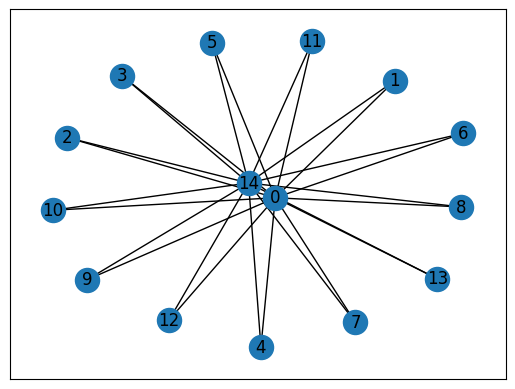

[[ 26.  26.  26. ... -26. -26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [-26.  26.  26. ... -26. -26.   0.]
 ...
 [-26. -26.  26. ...  26.  26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [-26. -26. -26. ...  26.  26.   0.]]
[[ 26.  26.  26. ... -26. -26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 ...
 [-26. -26.  26. ...  26.  26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [-26. -26. -26. ...  26.  26.   0.]]
[[ 26.  26.  26. ... -26. -26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [ 26. -26.  26. ... -26. -26.   0.]
 ...
 [-26. -26.  26. ...  26.  26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [-26. -26. -26. ...  26.  26.   0.]]
[[ 26.  26.  26. ... -26. -26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [ 26. -26.  26. ... -26. -26.   0.]
 ...
 [-26. -26. -26. ...  26.  26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [-26. -26. -26. ...  26.  26.   0.]]
[[ 26.  26.  26. ... -26. -26.   0.]
 [ 26.  26.  26. ... -26. -26.   0.]
 [ 26. -26.  2

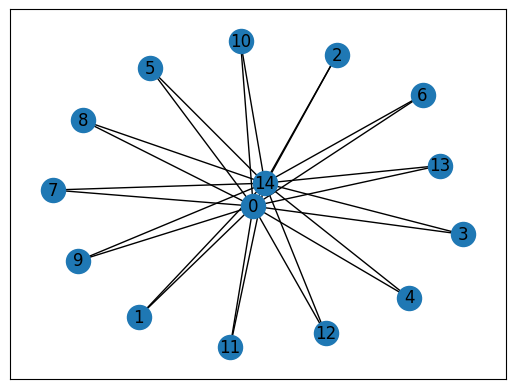

0.0000 0.1774 0.1758 0.1739 0.1750 0.1750 0.1755 0.1750 0.1786 0.1755 0.1806 0.1749 0.1767 0.1771 0.1861 
0.1491 0.0000 0.1356 0.1332 0.1581 0.1346 0.1470 0.1581 0.1392 0.1352 0.1419 0.1344 0.1367 0.1373 0.1491 
0.1440 0.1318 0.0000 0.1386 0.1284 0.1402 0.1292 0.1284 0.1334 0.1290 0.1362 0.1401 0.1425 0.1313 0.1440 
0.1391 0.1260 0.1352 0.0000 0.1224 0.1224 0.1232 0.1224 0.1395 0.1348 0.1307 0.1341 0.1248 0.1255 0.1391 
0.1419 0.1534 0.1275 0.1250 0.0000 0.1383 0.1389 0.1383 0.1314 0.1271 0.1342 0.1383 0.1406 0.1293 0.1419 
0.1422 0.1294 0.1388 0.1244 0.1377 0.0000 0.1267 0.1377 0.1311 0.1266 0.1341 0.1259 0.1284 0.1290 0.1422 
0.1433 0.1429 0.1288 0.1262 0.1395 0.1278 0.0000 0.1395 0.1445 0.1284 0.1356 0.1277 0.1301 0.1425 0.1433 
0.1419 0.1534 0.1275 0.1249 0.1383 0.1383 0.1389 0.0000 0.1432 0.1271 0.1342 0.1383 0.1288 0.1293 0.1419 
0.1529 0.1419 0.1398 0.1493 0.1388 0.1389 0.1513 0.1506 0.0000 0.1394 0.1460 0.1388 0.1410 0.1534 0.1529 
0.1436 0.1308 0.1283 0.1374 0.1273 0.1273 0.12

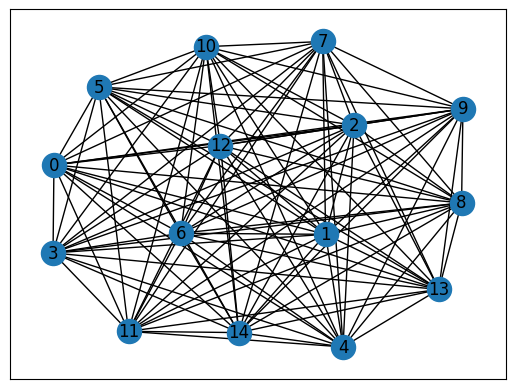

Maximum absolute error between true and estimated adjacency matrices: 0.8609


In [ ]:
# Parameters
graph_size = 6
num_sample = 1000
theta = 1
rand_sign = False
num_iter = 100

error = ising_learn(graph_size, num_sample, theta, rand_sign, num_iter)
print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")

#structure prediction

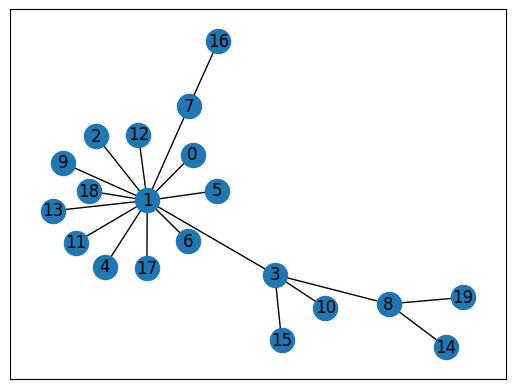

20
0.0000 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 
0.2195 0.0000 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 
0.2195 0.2195 0.0000 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 
0.2195 0.2195 0.2195 0.0000 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 
0.2195 0.2195 0.2195 0.2195 0.0000 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 
0.2195 0.2195 0.2195 0.2195 0.2195 0.0000 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 
0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.0000 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 0.2195 
0.2195 0.2

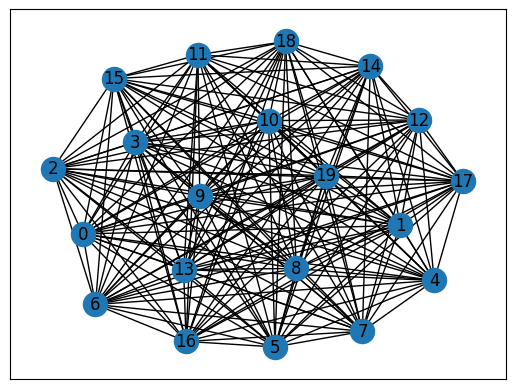

In [ ]:
def genCluster(s, theta, rand_sign,d,p):
    G = nx.powerlaw_cluster_graph(s,d,p);
    A = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            if i!=j and G.has_edge(i,j):
                A[i][j] = theta*(-1 if rand_sign and random.random()<.5 else 1)
    return A
graph_size = 20
max_num_sample = 100000
theta =20
rand_sign = False
num_iter = 1000
d=2
model = genCluster(graph_size,theta,rand_sign,1,.9)
showModel(model)
for i in range(1):
    samples = sampling_ising(model,max_num_sample)
    out = ising_learn_graph(graph_size, samples, theta, num_iter,graph_size*theta)
    showMat(out)
    showModel(out)

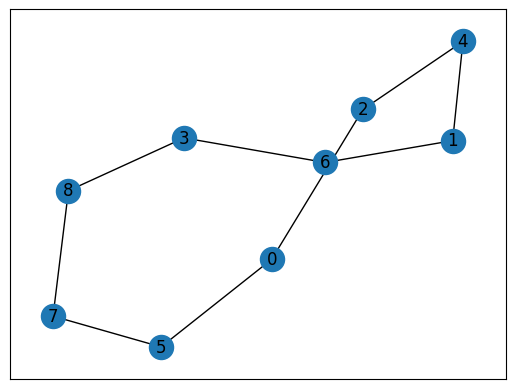

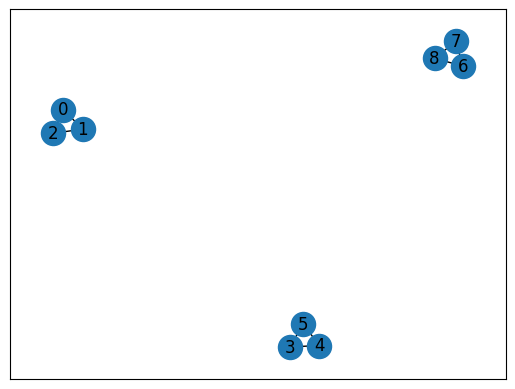

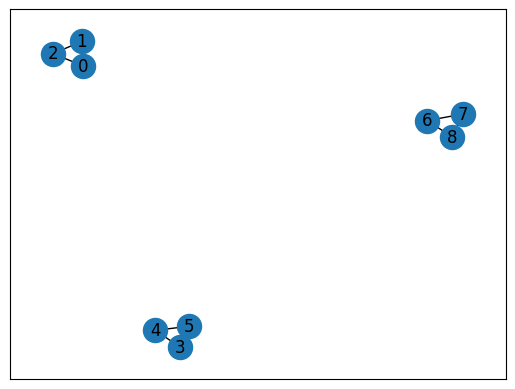

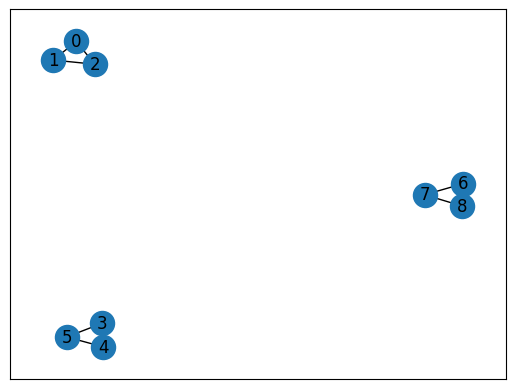

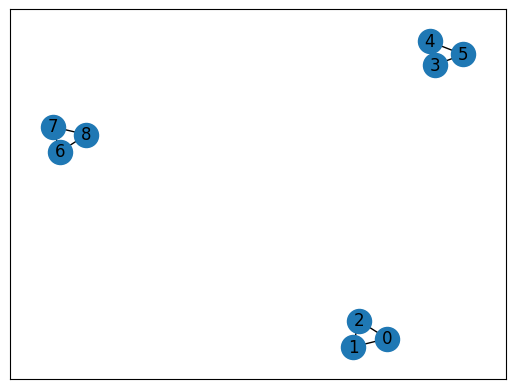

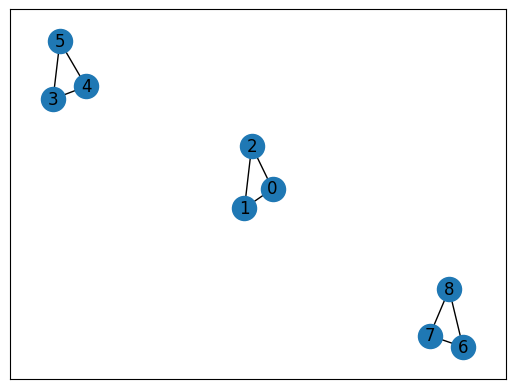

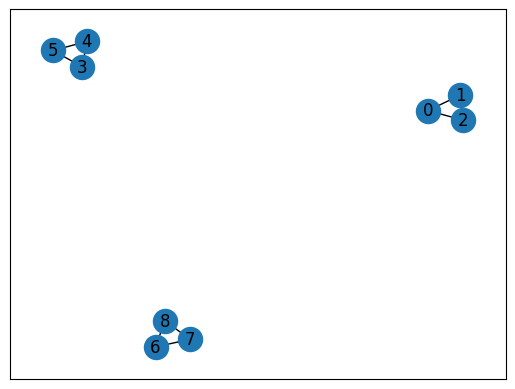

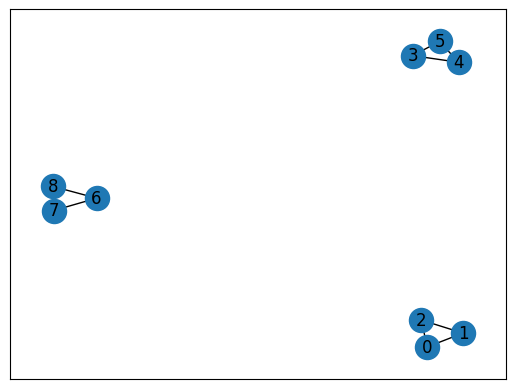

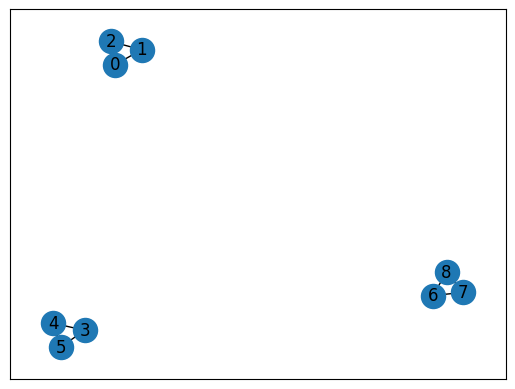

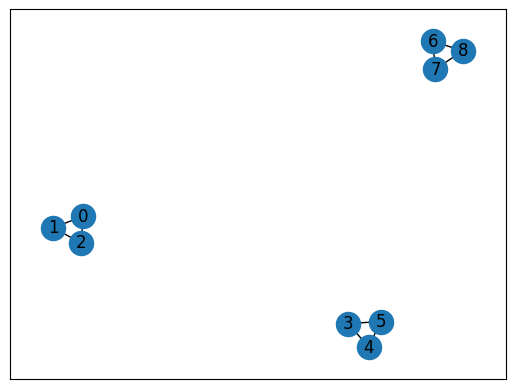

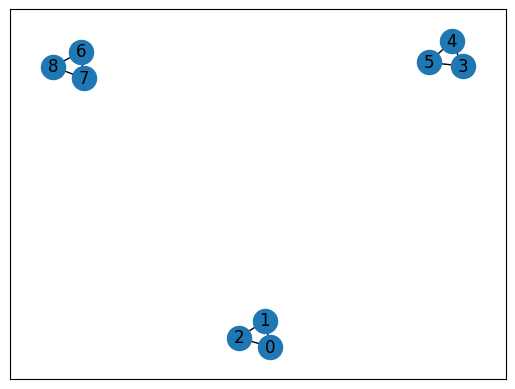

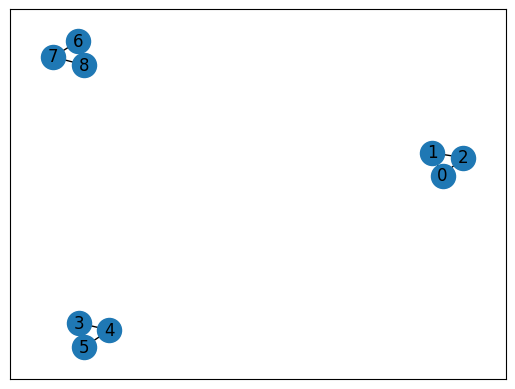

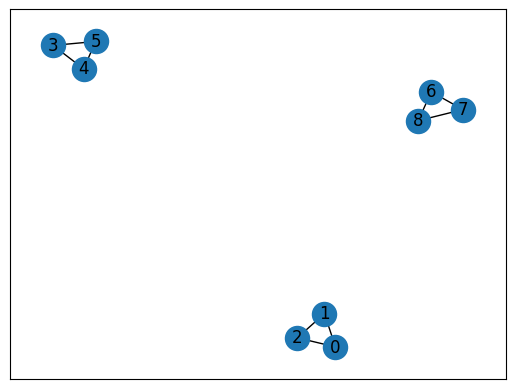

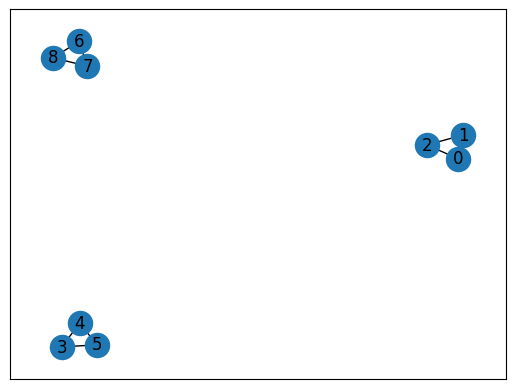

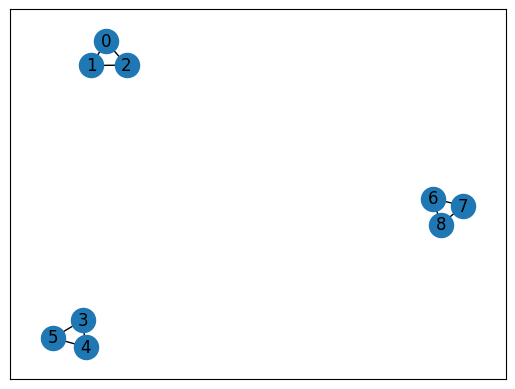

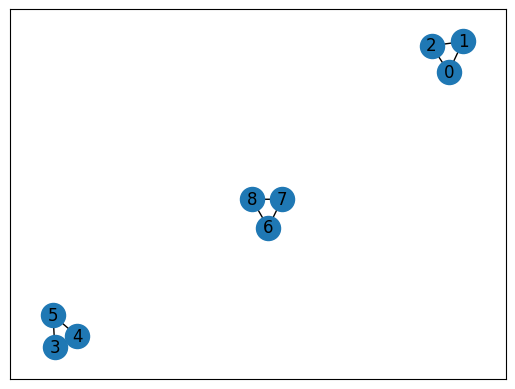

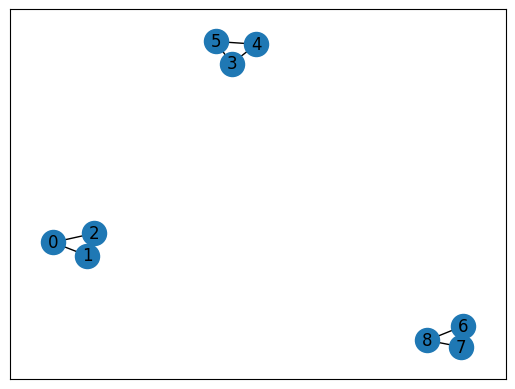

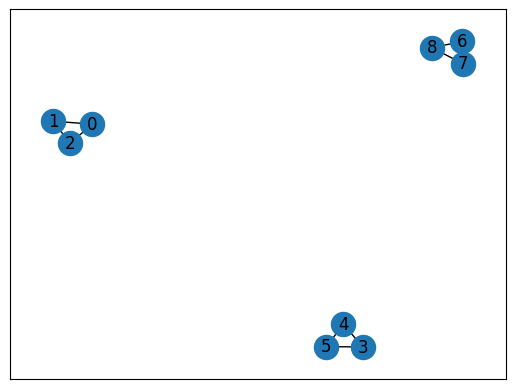

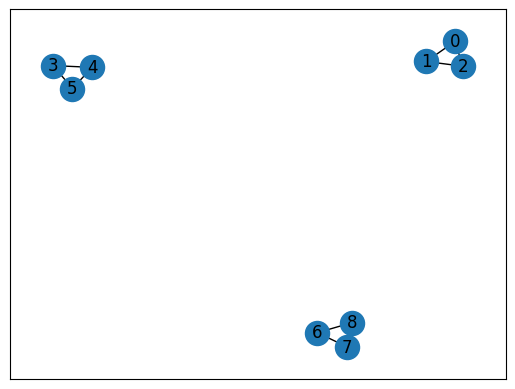

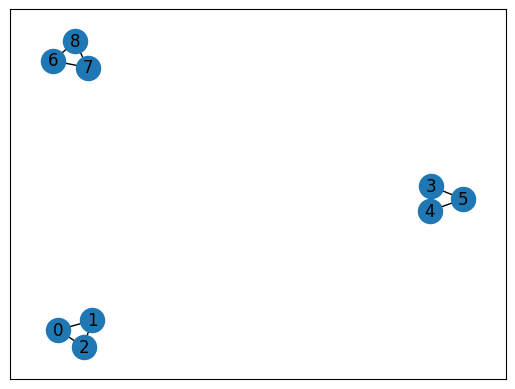

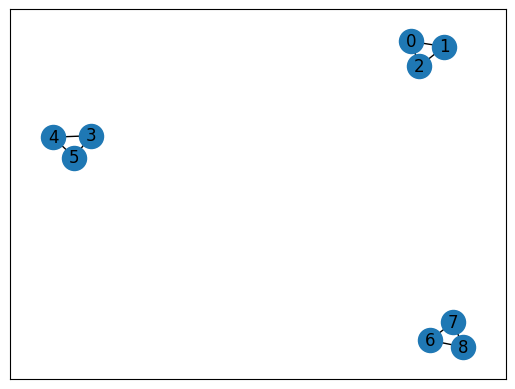

In [ ]:
graph_size = 8
max_num_sample = 100000
theta =40
rand_sign = False
num_iter = 1000
d=2
model = genDDegreeGraph(graph_size,theta,rand_sign,d)
showModel(model)
for i in range(20):
    samples = sampling_ising(model,max_num_sample)
    out = ising_learn_d_degree_graph_success(graph_size, samples, theta, num_iter,d)
    # showMat(out)
    showModel(out)


#divergence optimisation

In [ ]:
def getDivergence(A, B):
    s = A.shape[0]
    all_states = np.array([(np.array(list(bin(i)[2:].zfill(s)), dtype=int)*2-1) for i in range(2**s)])  #generates all states
    div=0;
    probsA = np.array([np.exp(x @ A @ x.T / 2) for x in all_states])
    probsA = probsA / probsA.sum()
    probsB = np.array([np.exp(x @ B @ x.T / 2) for x in all_states])
    probsB = probsB / probsB.sum()
    for i in range(2**s):
        div+=probsA[i]*np.log(probsA[i]/probsB[i]);
    return div

In [ ]:
graph_size = 14
max_num_sample = 100000
theta = .1
rand_sign = True
num_iter = 1000
d=3
model = genDDegreeGraph(graph_size,theta,rand_sign,d)
threshold = .035
l,r = 1,12
samples = sampling_ising(model,max_num_sample)
for m in [100,100000]:
    # m = int((l+r)/2)
    out = ising_learn_d_degree_graph_success(graph_size, samples[:m], theta, num_iter,d)
    div = getDivergence(model,out)
    print("divergence is ",div)
    if div<threshold:
        r=m
    else:
        l=m
    # print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")
print("final range - ",l,r)


divergence is  0.04969735198016974
divergence is  0.04970523204169419
final range -  100000 12


In [ ]:
def getSampleEstimate(theta,showDiv = False):
    graph_size = 14
    max_num_sample = 100000
    rand_sign = True
    num_iter = 500
    d=3
    model = genDDegreeGraph(graph_size,theta,rand_sign,d)
    l,r = 1,max_num_sample
    samples = sampling_ising(model,max_num_sample)
    while l<r-10:
        m = int((l+r)/2)
        out = ising_learn_d_degree_graph_success(graph_size, samples[:m], theta, num_iter,d)
        div = getDivergence(model,out)
        if showDiv:
            print("divergence is ",div,m)
        if div<threshold:
            r=m
        else:
            l=m
    return (l+r)//2
    # print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")
threshold = .032
getSampleEstimate(.2,True)

divergence is  0.21511996567330113 50000
divergence is  0.21511746485077277 75000
divergence is  0.21511912099392147 87500
divergence is  0.21512002118518642 93750
divergence is  0.2151199416032725 96875
divergence is  0.21511963971165807 98437
divergence is  0.21511930256111758 99218
divergence is  0.21511916084890695 99609
divergence is  0.21511915867864334 99804
divergence is  0.215119327938129 99902
divergence is  0.21511929015203618 99951
divergence is  0.21511929716386122 99975
divergence is  0.21511931076316826 99987
divergence is  0.21511931203367768 99993


99996

analysing theta =	 0.065
trial 	 0
divergence is  0.012637840592450445 50000
divergence is  0.012638185594158078 25000
divergence is  0.012637920043310756 12500
divergence is  0.012638804517695014 6250
divergence is  0.01263927957622813 3125
divergence is  0.012639163398987022 1563
divergence is  0.012642028769649254 782
divergence is  0.012643453073858007 391
divergence is  0.012635119576458163 196
divergence is  0.01263568967517671 98
divergence is  0.01263516427286886 49
divergence is  0.01264772404256387 25
divergence is  0.017742384760748766 13
divergence is  0.022831782817553933 7
trial 	 1
divergence is  0.016850039471889577 50000
divergence is  0.016850755043438703 25000
divergence is  0.016850860729675943 12500
divergence is  0.016849284710114532 6250
divergence is  0.016849712284032817 3125
divergence is  0.01685252440755169 1563
divergence is  0.016856297540091544 782
divergence is  0.016855395619956796 391
divergence is  0.01685264673423276 196
divergence is  0.016858301651

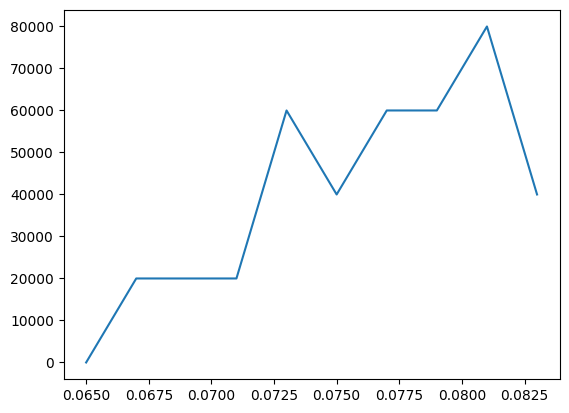

[0.065, 0.067, 0.06899999999999999, 0.071, 0.073, 0.075, 0.077, 0.079, 0.081, 0.08299999999999999] [5.2, 20006.0, 20003.600000000002, 20006.0, 60000.399999999994, 40003.200000000004, 60001.600000000006, 60000.40000000001, 79997.59999999999, 40002.0]


In [ ]:
import matplotlib.pyplot as plt
x,y = [],[]
size=5
threshold=.031
meanTheta = .075
delta = .002
iter = 10
for i in range(iter):
    theta= meanTheta+(i-iter//2)*delta
    print("analysing theta =\t",theta)
    s=0
    for _ in range(size):
        print("trial \t",_)
        s+=getSampleEstimate(theta,True)/size
    x.append(theta)
    y.append(s)
    theta+=.005
plt.plot(x,y)
plt.show()
print(x,y)

[5.2, 20006.0, 20003.600000000002, 20006.0, 60000.399999999994, 40003.200000000004, 60001.600000000006, 60000.40000000001, 79997.59999999999, 40002.0]
[ 1.64865863  9.90378751  9.90366754  9.90378751 11.00210651 10.59671473
 11.00212651 11.00210651 11.28975191 10.59668473]
[0.065, 0.067, 0.06899999999999999, 0.071, 0.073, 0.075, 0.077, 0.079, 0.081, 0.08299999999999999]


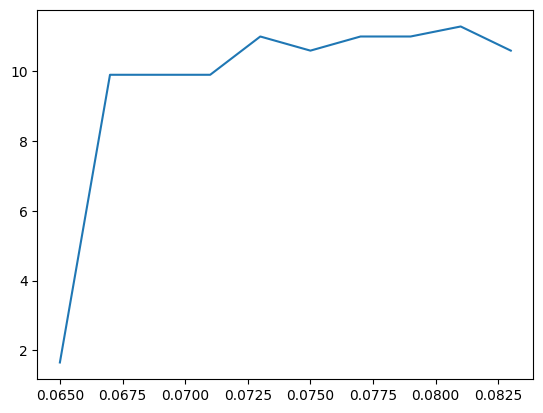

0.065 1.6486586255873816
0.067 9.903787507545125
0.06899999999999999 9.903667536338071
0.071 9.903787507545125
0.073 11.002106507848682
0.075 10.596714729896243
0.077 11.002126507515355
0.079 11.002106507848682
0.081 11.28975191320601
0.08299999999999999 10.596684731846114


In [ ]:
print(y)
print(np.log(y))
print(x)
plt.plot(x,np.log(y))
plt.show()
for i in range(len(x)):
    print(x[i],np.log(y)[i])

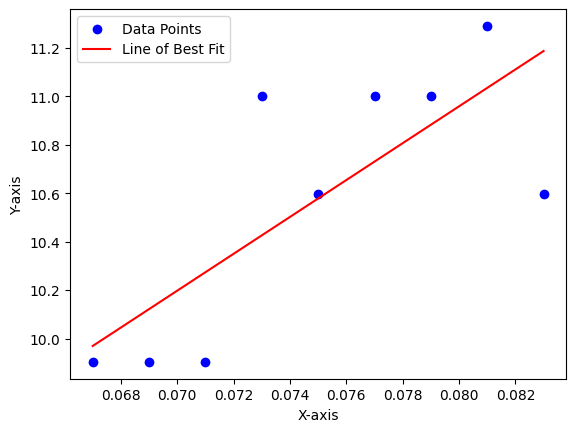

76.05416690067943 4.873796754625646


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.array(x,dtype = float)
Y = y.copy()
X = np.hstack([X[1:]])
Y = np.hstack([Y[1:]])
# Calculate the line of best fit
m, c = np.polyfit(X, np.log(Y), 1)

# Plot the scatter plot
plt.scatter(X, np.log(Y), color='blue', label='Data Points')

# Plot the line of best fit
plt.plot(X, m*X + c, color='red', label='Line of Best Fit')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()
print(m,c)

In [ ]:
import matplotlib.pyplot as plt
xTheta,yTheta = [],[]
size=5
graph_size = 14
threshold=.031
theta = .05
num_sample = 10000
num_iter = 1000
rand_sign = True
d=3
while theta<.1:
    print("analysing theta =\t",theta)
    s=0

    for _ in range(size):
        print("trial \t",_)
        model = genDDegreeGraph(graph_size,theta,rand_sign,num_sample,d)
        out = ising_learn_d_degree_graph_success(graph_size, sampling_ising(model,num_sample), theta, num_iter,d)
        div = getDivergence(model,out)
        s+=div/size
    xTheta.append(theta)
    yTheta.append(s)
    theta+=.005
plt.plot(xTheta,yTheta)
plt.show()
print(xTheta,yTheta)

analysing theta =	 0.05
trial 	 0


TypeError: genDDegreeGraph() takes 4 positional arguments but 5 were given